### OCI Data Science - Useful Tips
<details>
<summary><font size="2">Check for Public Internet Access</font></summary>

```python
import requests
response = requests.get("https://oracle.com")
assert response.status_code==200, "Internet connection failed"
```
</details>
<details>
<summary><font size="2">Helpful Documentation </font></summary>
<ul><li><a href="https://docs.cloud.oracle.com/en-us/iaas/data-science/using/data-science.htm">Data Science Service Documentation</a></li>
<li><a href="https://docs.cloud.oracle.com/iaas/tools/ads-sdk/latest/index.html">ADS documentation</a></li>
</ul>
</details>
<details>
<summary><font size="2">Typical Cell Imports and Settings for ADS</font></summary>

```python
%load_ext autoreload
%autoreload 2
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

import logging
logging.basicConfig(format='%(levelname)s:%(message)s', level=logging.ERROR)

import ads
from ads.dataset.factory import DatasetFactory
from ads.automl.provider import OracleAutoMLProvider
from ads.automl.driver import AutoML
from ads.evaluations.evaluator import ADSEvaluator
from ads.common.data import ADSData
from ads.explanations.explainer import ADSExplainer
from ads.explanations.mlx_global_explainer import MLXGlobalExplainer
from ads.explanations.mlx_local_explainer import MLXLocalExplainer
from ads.catalog.model import ModelCatalog
from ads.common.model_artifact import ModelArtifact
```
</details>
<details>
<summary><font size="2">Useful Environment Variables</font></summary>

```python
import os
print(os.environ["NB_SESSION_COMPARTMENT_OCID"])
print(os.environ["PROJECT_OCID"])
print(os.environ["USER_OCID"])
print(os.environ["TENANCY_OCID"])
print(os.environ["NB_REGION"])
```
</details>

In [ ]:
! pip install prophet
! pip install -U oci
! pip install -U oci-cli
! pip install -U oracle-ads

In [26]:
import os
import prophet
from os import path
import json
import pandas as pd
from prophet import Prophet
from prophet.serialize import model_to_json, model_from_json

import tempfile

from ads.common.model_export_util import prepare_generic_model
from ads.common.model_metadata import (MetadataCustomCategory,
                                       UseCaseType,
                                       Framework)
from ads.feature_engineering.schema import Expression, Schema
from ads.catalog.model import ModelCatalog

In [2]:
df = pd.read_csv('https://raw.githubusercontent.com/facebook/prophet/main/examples/example_wp_log_peyton_manning.csv')
df.head()

ds         y
0  2007-12-10  9.590761
1  2007-12-11  8.519590
2  2007-12-12  8.183677
3  2007-12-13  8.072467
4  2007-12-14  7.893572

In [3]:
m = Prophet()
m.fit(df)

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpaj__j6zd/chx2d4cx.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpaj__j6zd/rg3lj68y.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/home/datascience/conda/dataexpl_p37_cpu_prophet/lib/python3.7/site-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=44742', 'data', 'file=/tmp/tmpaj__j6zd/chx2d4cx.json', 'init=/tmp/tmpaj__j6zd/rg3lj68y.json', 'output', 'file=/tmp/tmpaj__j6zd/prophet_modelv813qz9u/prophet_model-20221004184648.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']


18:46:48 - cmdstanpy - INFO - Chain [1] start processing


INFO:cmdstanpy:Chain [1] start processing


18:46:49 - cmdstanpy - INFO - Chain [1] done processing


INFO:cmdstanpy:Chain [1] done processing


In [4]:
future = m.make_future_dataframe(periods=365)
future.tail()

ds
3265 2017-01-15
3266 2017-01-16
3267 2017-01-17
3268 2017-01-18
3269 2017-01-19

In [5]:
forecast = m.predict(future)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

ds      yhat  yhat_lower  yhat_upper
3265 2017-01-15  8.208452    7.517488    8.895581
3266 2017-01-16  8.533442    7.787951    9.292648
3267 2017-01-17  8.320853    7.575109    9.059120
3268 2017-01-18  8.153517    7.455323    8.897619
3269 2017-01-19  8.165423    7.420200    8.864348

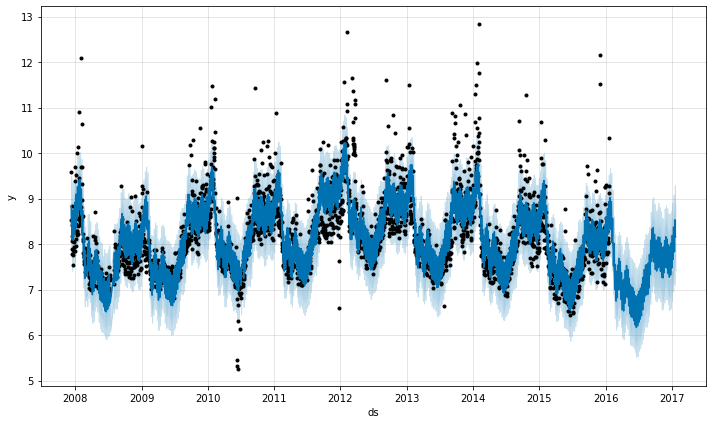

In [6]:
fig1 = m.plot(forecast)

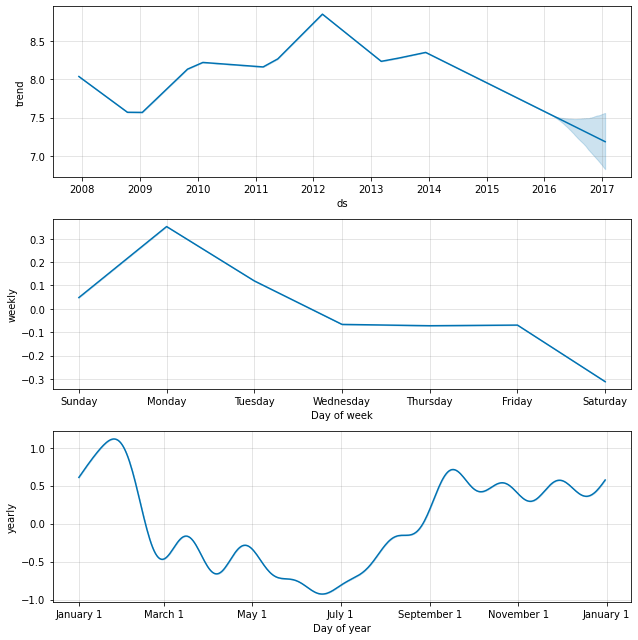

In [7]:
fig2 = m.plot_components(forecast)

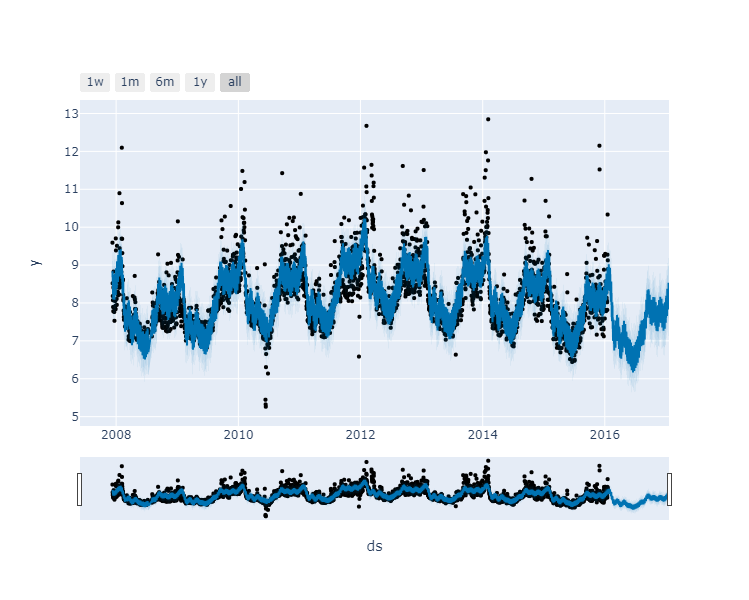

In [8]:
from prophet.plot import plot_plotly, plot_components_plotly

plot_plotly(m, forecast)

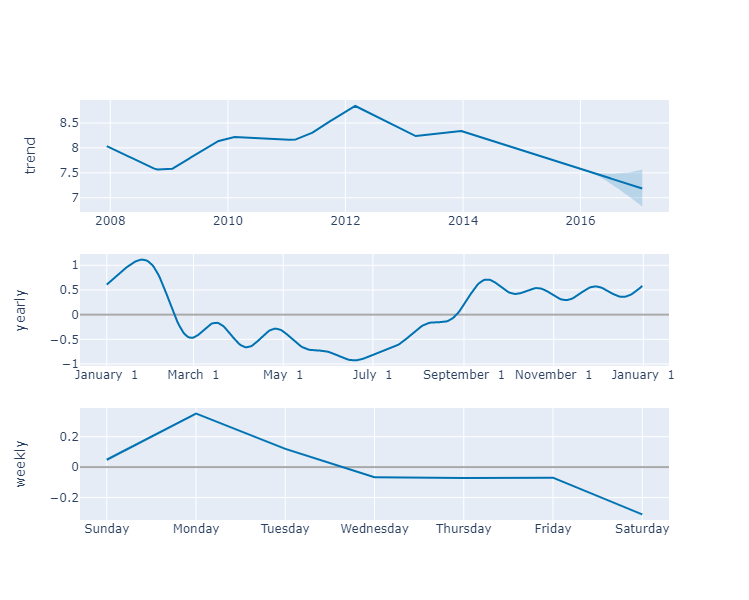

In [9]:
plot_components_plotly(m, forecast)

In [10]:
with open('serialized_model.json', 'w') as fout:
    fout.write(model_to_json(m))  # Save model

In [11]:
path_to_prophet_model_artifact = os.path.join(os.environ['PWD'], "modelo_serializado")
path_to_prophet_model_artifact

'/home/datascience/Prophet/modelo_serializado'

In [12]:
prophet_model_artifact = prepare_generic_model(path_to_prophet_model_artifact,
                                               model=m,
                                               force_overwrite=True,
                                               data_science_env=True,
                                              )

loop1:   0%|          | 0/4 [00:00<?, ?it/s]

In [13]:
prophet_model_artifact.metadata_taxonomy['UseCaseType'].value = UseCaseType.TIME_SERIES_FORECASTING
prophet_model_artifact.metadata_taxonomy['Framework'].value = Framework.PROPHET
prophet_model_artifact.metadata_taxonomy['FrameworkVersion'].value = str(prophet.__version__)
prophet_model_artifact.metadata_taxonomy['Hyperparameters'].value = {
    "changepoint_prior_scale":m.changepoint_prior_scale,
    "seasonality_prior_scale":m.seasonality_prior_scale,
    "component_modes":m.component_modes
}
prophet_model_artifact.metadata_taxonomy['Algorithm'].value = 'Additive Regression Model'

In [14]:
prophet_model_artifact.metadata_taxonomy

data:
- key: Algorithm
  value: Additive Regression Model
- key: Framework
  value: prophet
- key: Hyperparameters
  value:
    changepoint_prior_scale: 0.05
    component_modes:
      additive:
      - yearly
      - weekly
      - additive_terms
      - extra_regressors_additive
      - holidays
      multiplicative:
      - multiplicative_terms
      - extra_regressors_multiplicative
    seasonality_prior_scale: 10.0
- key: FrameworkVersion
  value: 1.1.1
- key: UseCaseType
  value: time_series_forecasting
- key: ArtifactTestResults
  value: null

In [15]:
import cloudpickle
with open(os.path.join(path_to_prophet_model_artifact, "model.pkl"), "wb") as outfile:
    cloudpickle.dump(m, outfile)

In [18]:
os.system("pip freeze > '{}'".format(os.path.join(path_to_prophet_model_artifact, "backup-requirements.txt")))

0

In [19]:
prophet_model_artifact.reload(model_file_name='model.pkl')

Start loading model.pkl from model directory /home/datascience/Prophet/modelo_serializado ...
Model is successfully loaded.
Start loading model.pkl from model directory /home/datascience/Prophet/modelo_serializado ...
Model is successfully loaded.


In [20]:
prophet_model_artifact.introspect()

['.ipynb_checkpoints', 'model.pkl', 'score.py', 'test_json_output.json', 'backup-requirements.txt', 'runtime.yaml']


Test key  \
0     runtime_env_path   
1   runtime_env_python   
2   runtime_path_exist   
3      runtime_version   
4         runtime_yaml   
5     score_load_model   
6        score_predict   
7    score_predict_arg   
8   score_predict_data   
9             score_py   
10        score_syntax   

                                                                                                Test name  \
0                                             Check that field MODEL_DEPLOYMENT.INFERENCE_ENV_PATH is set   
1           Check that field MODEL_DEPLOYMENT.INFERENCE_PYTHON_VERSION is set to a value of 3.6 or higher   
2                             Check that the file path in MODEL_DEPLOYMENT.INFERENCE_ENV_PATH is correct.   
3                                                   Check that field MODEL_ARTIFACT_VERSION is set to 3.0   
4   Check that the file "runtime.yaml" exists and is in the top level directory of the artifact directory   
5                                                                      Check that load_model() is defined   
6                                                                         Check that predict() is defined   
7                        Check that all other arguments in predict() are optional and have default values   
8                                     Check that the only required argument for predict() is named "data"   
9       Check that the file "score.py" exists and is in the top level directory of the artifact directory   
10                                                                         Check for Python syntax errors   

    Result Message  
0   Passed          
1   Passed          
2   Passed          
3   Passed          
4   Passed          
5   Passed          
6   Passed          
7   Passed          
8   Passed          
9   Passed          
10  Passed

In [21]:
prophet_model_artifact.metadata_taxonomy['ArtifactTestResults']

key: ArtifactTestResults
value:
  runtime_env_path:
    category: conda_env
    description: Check that field MODEL_DEPLOYMENT.INFERENCE_ENV_PATH is set
    error_msg: In runtime.yaml, the key MODEL_DEPLOYMENT.INFERENCE_ENV_PATH must have
      a value.
    success: true
    value: oci://dssilva_conda@id3kyspkytmr/conda_environments/cpu/Data Exploration
      and Manipulation for CPU Python 3.7 with Prophet/1.0/dataexpl_p37_cpu_prophet
  runtime_env_python:
    category: conda_env
    description: Check that field MODEL_DEPLOYMENT.INFERENCE_PYTHON_VERSION is set
      to a value of 3.6 or higher
    error_msg: In runtime.yaml, the key MODEL_DEPLOYMENT.INFERENCE_PYTHON_VERSION
      must be set to a value of 3.6 or higher.
    success: true
    value: 3.7.12
  runtime_path_exist:
    category: conda_env
    description: Check that the file path in MODEL_DEPLOYMENT.INFERENCE_ENV_PATH is
      correct.
    error_msg: In runtime.yaml, the key MODEL_DEPLOYMENT.INFERENCE_ENV_PATH does not
  

In [22]:
prophet_model_artifact.metadata_taxonomy.to_dataframe()

Key  \
0            Algorithm   
1  ArtifactTestResults   
2            Framework   
3     FrameworkVersion   
4      Hyperparameters   
5          UseCaseType   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                  Value  
0                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                 

In [23]:
# Saving the model artifact to the model catalog:
prophet_model = prophet_model_artifact.save(project_id=os.environ['PROJECT_OCID'],
                                  compartment_id=os.environ['NB_SESSION_COMPARTMENT_OCID'],
                                  training_id=os.environ['NB_SESSION_OCID'],
                                  display_name="Phophet Forecasting Example",
                                  description="A simple Prophet Forecasting Model",
                                  ignore_pending_changes=True,
                                  timeout=100,
                                  ignore_introspection=False
                                 )
prophet_model

['.ipynb_checkpoints', 'model.pkl', 'score.py', 'test_json_output.json', 'backup-requirements.txt', 'runtime.yaml']


loop1:   0%|          | 0/5 [00:00<?, ?it/s]

<style type="text/css">
#T_8f068_row0_col0, #T_8f068_row1_col0, #T_8f068_row2_col0, #T_8f068_row3_col0, #T_8f068_row4_col0, #T_8f068_row5_col0, #T_8f068_row6_col0, #T_8f068_row7_col0, #T_8f068_row8_col0, #T_8f068_row9_col0, #T_8f068_row10_col0, #T_8f068_row11_col0, #T_8f068_row12_col0, #T_8f068_row13_col0 {
  margin-left: 0px;
}
</style>
<table id="T_8f068_">
  <thead>
    <tr>
      <th class="blank level0" >&nbsp;</th>
      <th class="col_heading level0 col0" ></th>
    </tr>
  </thead>
  <tbody>
    <tr>
      <th id="T_8f068_level0_row0" class="row_heading level0 row0" >display_name</th>
      <td id="T_8f068_row0_col0" class="data row0 col0" >Phophet Forecasting Example</td>
    </tr>
    <tr>
      <th id="T_8f068_level0_row1" class="row_heading level0 row1" >description</th>
      <td id="T_8f068_row1_col0" class="data row1 col0" >A simple Prophet Forecasting Model</td>
    </tr>
    <tr>
      <th id="T_8f068_level0_row2" class="row_heading level0 row2" >freeform_tags</th>
      <td id="T_8f068_row2_col0" class="data row2 col0" >{}</td>
    </tr>
    <tr>
      <th id="T_8f068_level0_row3" class="row_heading level0 row3" >defined_tags</th>
      <td id="T_8f068_row3_col0" class="data row3 col0" >{'Oracle-Tags': {'CreatedBy': 'oracleidentitycloudservice/douglas.s.silva@oracle.com', 'CreatedOn': '2022-10-04T18:55:15.663Z'}}</td>
    </tr>
    <tr>
      <th id="T_8f068_level0_row4" class="row_heading level0 row4" >repository_url</th>
      <td id="T_8f068_row4_col0" class="data row4 col0" >https://github.com/dougsouzars/Prophet.git</td>
    </tr>
    <tr>
      <th id="T_8f068_level0_row5" class="row_heading level0 row5" >git_branch</th>
      <td id="T_8f068_row5_col0" class="data row5 col0" >master</td>
    </tr>
    <tr>
      <th id="T_8f068_level0_row6" class="row_heading level0 row6" >git_commit</th>
      <td id="T_8f068_row6_col0" class="data row6 col0" >eaf625cfd96b44a27f97f03e84ba234eac5ee0aa</td>
    </tr>
    <tr>
      <th id="T_8f068_level0_row7" class="row_heading level0 row7" >script_dir</th>
      <td id="T_8f068_row7_col0" class="data row7 col0" >/home/datascience/Prophet/modelo_serializado</td>
    </tr>
    <tr>
      <th id="T_8f068_level0_row8" class="row_heading level0 row8" >training_script</th>
      <td id="T_8f068_row8_col0" class="data row8 col0" >None</td>
    </tr>
    <tr>
      <th id="T_8f068_level0_row9" class="row_heading level0 row9" >training_id</th>
      <td id="T_8f068_row9_col0" class="data row9 col0" >ocid1.datasciencenotebooksession.oc1.sa-saopaulo-1.amaaaaaatsbrckqarxcb2rhnczz54pzkp66pqte7xyiw4qjt3jtp2oskc25q</td>
    </tr>
    <tr>
      <th id="T_8f068_level0_row10" class="row_heading level0 row10" >schema_input</th>
      <td id="T_8f068_row10_col0" class="data row10 col0" >{'schema': [], 'version': '1.1'}</td>
    </tr>
    <tr>
      <th id="T_8f068_level0_row11" class="row_heading level0 row11" >schema_output</th>
      <td id="T_8f068_row11_col0" class="data row11 col0" >{'schema': [], 'version': '1.1'}</td>
    </tr>
    <tr>
      <th id="T_8f068_level0_row12" class="row_heading level0 row12" >metadata_custom</th>
      <td id="T_8f068_row12_col0" class="data row12 col0" >{'data': [{'key': 'ModelArtifacts', 'value': 'model.pkl, score.py, test_json_output.json, backup-requirements.txt, runtime.yaml, .ipynb_checkpoints, .ipynb_checkpoints/runtime-checkpoint.yaml, .ipynb_checkpoints/backup-requirements-checkpoint.txt', 'description': 'The list of files located in artifacts folder.', 'category': 'Training Environment'}, {'key': 'CondaEnvironment', 'value': 'dataexpl_p37_cpu_prophet', 'description': 'The conda environment where the model was trained.', 'category': 'Training Environment'}, {'key': 'ModelSerializationFormat', 'value': 'pkl', 'description': 'The model serialization format.', 'category': 'Training Profile'}, {'key': 'SlugName', 'value': 'dataexpl_p37_cpu_prophet', 'description': 'The slug name of the training conda environment.', 'category': 'Training Environm

In [24]:
prophet_model.id

'ocid1.datasciencemodel.oc1.sa-saopaulo-1.amaaaaaatsbrckqa2qgj7vsyejjvs4szqv6bje2zy6xwjl2aps4glwk65pza'

In [28]:
download_path = os.path.join(os.environ['PWD'], "download_modelo")

In [30]:
dwnld_model = prophet_model_artifact.from_model_catalog(prophet_model.id, download_path, force_overwrite=True)

loop1:   0%|          | 0/6 [00:00<?, ?it/s]

In [38]:
dwnld_model.reload(model_file_name='model.pkl')

Start loading model.pkl from model directory /home/datascience/Prophet/download_modelo ...
Model is successfully loaded.
Start loading model.pkl from model directory /home/datascience/Prophet/download_modelo ...
Model is successfully loaded.


In [39]:
dwnld_model.predict(future)

ds     trend  yhat_lower  yhat_upper  trend_lower  trend_upper  \
0    2007-12-10  8.035820    8.164249    9.433356     8.035820     8.035820   
1    2007-12-11  8.034297    7.980415    9.183880     8.034297     8.034297   
2    2007-12-12  8.032774    7.782208    8.940856     8.032774     8.032774   
3    2007-12-13  8.031250    7.715533    8.939029     8.031250     8.031250   
4    2007-12-14  8.029727    7.684709    8.961469     8.029727     8.029727   
...         ...       ...         ...         ...          ...          ...   
3265 2017-01-15  7.190312    7.505118    8.919363     6.860023     7.505596   
3266 2017-01-16  7.189287    7.831811    9.226150     6.857767     7.505762   
3267 2017-01-17  7.188261    7.626401    9.025159     6.855638     7.505754   
3268 2017-01-18  7.187236    7.421154    8.855401     6.853509     7.506814   
3269 2017-01-19  7.186211    7.447550    8.818701     6.850602     7.507352   

      additive_terms  additive_terms_lower  additive_terms_upper    weekly  \
0           0.802814              0.802814              0.802814  0.352279   
1           0.552915              0.552915              0.552915  0.119616   
2           0.350351              0.350351              0.350351 -0.066648   
3           0.329798              0.329798              0.329798 -0.072279   
4           0.319379              0.319379              0.319379 -0.069561   
...              ...                   ...                   ...       ...   
3265        1.018140              1.018140              1.018140  0.048305   
3266        1.344156              1.344156              1.344156  0.352279   
3267        1.132592              1.132592              1.132592  0.119616   
3268        0.966281              0.966281              0.966281 -0.066648   
3269        0.979212              0.979212              0.979212 -0.072279   

      weekly_lower  weekly_upper    yearly  yearly_lower  yearly_upper  \
0         0.352279      0.352279  0.450535      0.450535      0.450535   
1         0.119616      0.119616  0.433299      0.433299      0.433299   
2        -0.066648     -0.066648  0.416999      0.416999      0.416999   
3        -0.072279     -0.072279  0.402077      0.402077      0.402077   
4        -0.069561     -0.069561  0.388940      0.388940      0.388940   
...            ...           ...       ...           ...           ...   
3265      0.048305      0.048305  0.969835      0.969835      0.969835   
3266      0.352279      0.352279  0.991877      0.991877      0.991877   
3267      0.119616      0.119616  1.012976      1.012976      1.012976   
3268     -0.066648     -0.066648  1.032929      1.032929      1.032929   
3269     -0.072279     -0.072279  1.051492      1.051492      1.051492   

      multiplicative_terms  multiplicative_terms_lower  \
0                      0.0                         0.0   
1                      0.0                         0.0   
2                      0.0                         0.0   
3                      0.0                         0.0   
4                      0.0                         0.0   
...                    ...                         ...   
3265                   0.0                         0.0   
3266                   0.0                         0.0   
3267                   0.0                         0.0   
3268                   0.0                         0.0   
3269                   0.0                         0.0   

      multiplicative_terms_upper      yhat  
0                            0.0  8.838634  
1                            0.0  8.587212  
2                            0.0  8.383125  
3                            0.0  8.361048  
4                            0.0  8.349107  
...                          ...       ...  
3265                         0.0  8.208452  
3266                         0.0  8.533442  
3267                         0.0  8.320853  
3268                         0.0  8.153517  
3269                         0.0  8.165423  

